The following template should work with the code directly in github (dont need any other downloads).

Getting FEs of four small supercells of Veliparib using OPLS forcefield:

In [ ]:
''' Note 1:

This information might be redundant in later versions of the library.
A wrapper class to handle a pipeline similar to the one in this notebook will be added with the next paper release.
In that wrapped all of the .py scripts will be managed internally, and result retrieval should be also made easier.

Note: OPLS is relatively slow to run in the current implementation when atom_order_PDB_match_itp = False in SingleComponent
    
    Note to self: [Simplest way to resolve, that will be used in further work, is discussed below. 
                   NB: In further work a different folder OPLS_sc instead of GAFF_sc will be used for the following steps.]
                    
    Reasons:
        Initialising SingleComponent with;
            (atom_order_PDB_match_itp = False) AND (FF_name = 'OPLS')
        causes: 
            each supercell configuration (r : (N,3)) to be permuted along axis=0, when saving a frame or evaluating a frame
            this step becomes expensive when saving many trajectory frames or evaluating energy of many supercells
        
To improve the efficiency, bypassing the limitation described above, requires starting from the beginning:
    'starting from the beginning' means reordering atoms of ideal unitcell or supercells to match the ordering expected by OPLS
    
    The (optional) steps to do this, in relation to this notebook, are:
    
        > in the '/O/MM/GAFF_sc/veliparib/misc' folder:
            leave the following files as they are:
                LigParGen_output_veliparib.itp
                LigParGen_output_veliparib.gro 
                LigParGen_output_veliparib.pdb
            delete all other *OPLS* and *LigParGen* files
            
        > in the '/O/MM/GAFF_sc/veliparib' folder:
            reorder atoms of each PDB_ideal_supercell used later to match the ordering of atoms in LigParGen_output_veliparib.pdb,
            using the following script:
            
                """
                #Inputs for function 'reorder_to_match_LigParGen_' (this function also mentioned in sc_system.py):
            
                mol_name = 'veliparib'
                n_atoms_mol = 34
                PDB_to_reorder = f'{mol_name}_{form}_unitcell_cell{cell}.pdb'
                path_mol_dir = f'./O/MM/GAFF_sc/{mol_name}'
            
                def reorder_to_match_LigParGen_(mol_name, PDB_to_reorder, path_mol_dir, n_atoms_mol):
                
                    # NB: to use reorder_atoms_unitcell_, need to have /temp folder next to the /misc folder
                    # the output will be in the main folder with name PDB_to_reorder+'_reordered'.pdb
                    # remove the '_reordered' part by hand if needed
    
                    name_structure_file = 'LigParGen_output_'+mol_name
                    reordered_PDB = reorder_atoms_unitcell_(PDB_to_reorder,
                                                            path_mol_dir+name_structure_file+'.pdb', # reference ordering
                                                            n_atoms_mol=n_atoms_mol)
                    return reordered_PDB
                """
        > in the script below:
            change PDB_ideal_supercell:
                from: PDB_ideal_supercell = f'./O/MM/GAFF_sc/{name}/{name}_{form}_unitcell_cell{cell}.pdb'
                to:   PDB_ideal_supercell = f'./O/MM/GAFF_sc/{name}/{name}_{form}_unitcell_cell{cell}_reordered.pdb'
            change atom_order_PDB_match_itp:
                from: atom_order_PDB_match_itp = False
                to  : atom_order_PDB_match_itp = True
    
Alternatively can just set FF_name = 'GAFF' and ignored all the above steps. 
This should replicated the results from the paper in conditions that are analogous to those used for the paper.
'''


In [ ]:
''' Note 2:
#To create supercells from unitcells automatically:

    # (1) can first check the order of increasing supercell size: 
    [NB: the method (get_unitcell_stack_order_) was not tested properly so far. In the paper this step was done by hand.]
    
    form = 'I' ; n_mol_unitcell=8 ; cell ='111'
    PDB_unitcell = f'./O/MM/GAFF_sc/{name}/{name}_{form}_unitcell_cell{cell}.pdb'
    output = get_unitcell_stack_order_(PDB_to_box_(PDB_unitcell), n_mol_unitcell, top_n=10)
    print('Form',form,'supercells possible:') ; print(output) ; print('')
    
    form = 'II' ; n_mol_unitcell=3 ; cell ='111'
    PDB_unitcell = f'./O/MM/GAFF_sc/{name}/{name}_{form}_unitcell_cell{cell}.pdb'
    output = get_unitcell_stack_order_(PDB_to_box_(PDB_unitcell), n_mol_unitcell, top_n=10)
    print('Form',form,'supercells possible:') ; print(output) ; print('')

    # (2) can then run:
    
    # n_mol_supercell = # chose from above output
    # PDB_supercell = supercell_from_unitcell_(PDB_unitcell, cell=output[n_mol_supercell], save_output=True)[-1]
'''

In [ ]:

name = 'veliparib'
n_atoms_mol = 34
T = 300
FF_name = 'OPLS'
atom_order_PDB_match_itp = False
PME_cutoff = 0.35

form_cell_pairs = [['I','111'], ['I','121'], ['II','131'], ['II','221']]

''' equilibrate.py

from O.MM.sc_system import *
for form_cell in form_cell_pairs:
    form, cell = form_cell
    try:
        PDB_ideal_supercell = f'./O/MM/GAFF_sc/{name}/{name}_{form}_unitcell_cell{cell}.pdb'
        sc = SingleComponent(PDB = PDB_ideal_supercell, n_atoms_mol=n_atoms_mol, name=name, FF_name=FF_name, atom_order_PDB_match_itp=atom_order_PDB_match_itp)
        sc.initialise_system_(PME_cutoff=PME_cutoff, nonbondedMethod=app.PME)
        sc.initialise_simulation_(timestep_ps=0.002, P=1, T=T, barostat_type=2)
        sc.run_simulation_(50000, 50)
        sc._xyz = tidy_crystal_xyz_(sc.xyz, sc.boxes, n_atoms_mol=sc.n_atoms_mol, ind_rO=10)
        sc.save_simulation_data_(f'./O/MM/GAFF_sc/{name}/data/{name}_{FF_name.lower()}_NPT_dataset_Form_{form}_Cell_{cell}_Temp_{T}')
        index = get_index_average_box_automatic_(sc.boxes)
        sc.save_pdb_(sc.xyz[index], b=sc.boxes[index], name=f'./O/MM/GAFF_sc/{name}/{name}_{FF_name.lower()}_equilibrated_Form_{form}_Cell_{cell}_Temp_{T}.pdb')
        print('finished:',form,cell)
        del sc
    except:
        print('!! problem in:',form,cell)
        
'''

''' run_nvt.py

from O.MM.sc_system import *
for form_cell in form_cell_pairs:
    form, cell = form_cell
    try:
        PDB_eqm_supercell = f'./O/MM/GAFF_sc/{name}/{name}_{FF_name.lower()}_equilibrated_Form_{form}_Cell_{cell}_Temp_{T}.pdb'
        sc = SingleComponent(PDB = PDB_eqm_supercell, n_atoms_mol=n_atoms_mol, name=name, FF_name=FF_name, atom_order_PDB_match_itp=atom_order_PDB_match_itp)
        sc.initialise_system_(PME_cutoff=PME_cutoff, nonbondedMethod=app.PME)
        sc.initialise_simulation_(timestep_ps = 0.002, P = None, T = T, minimise = True)
        sc.simulation.step(200*50)
        sc.run_simulation_(sc.n_mol*18750, 50)
        sc.save_simulation_data_(f'./O/MM/GAFF_sc/{name}/data/{name}_{FF_name.lower()}_NVT_dataset_Form_{form}_Cell_{cell}_Temp_{T}')
        print('finished:',form,cell)
        del sc
    except: 
    
        print('!! problem in:',form,cell)
'''

''' train_pgm.py

from O.interface import *

for form_cell in form_cell_pairs:
    form, cell = form_cell
    if form == 'I': n_mol_unitcells = [8],
    else: n_mol_unitcells = [8],
    try:
        nn = NN_interface_sc_multimap(
                        name = f'{name}_{FF_name.lower()}_Form_{form}_Cell_{cell}_Temp_{T}',
                        paths_datasets = [f'./O/MM/GAFF_sc/{name}/data/{name}_{FF_name.lower()}_NVT_dataset_Form_{form}_Cell_{cell}_Temp_{T}',],
                        running_in_notebook = False,
                        training = True,
                        model_class = PGMcrys_v1,
                        )
        nn.set_ic_map_step1(ind_root_atom=5, option=0)
        nn.set_ic_map_step2(check_PES=True)
        nn.set_ic_map_step3(n_mol_unitcells=[8,])
        nn.set_model(n_layers = 4, learning_rate=0.001, n_att_heads=4, evaluation_batch_size=5000)
        nn.set_trainer(n_batches_between_evaluations=50)
        n_batches = 5000
        print('training for n_batches =',n_batches)
        nn.train(n_batches = n_batches, save_misc = True, save_BAR = True, test_inverse = False, evaluate_on_training_data = False)
        nn.load_misc_()
        nn.solve_BAR_using_pymbar_(rerun=True)
        nn.save_samples_(20000)
        nn.save_model_()
        print('finished:',form,cell)
        del nn
    except: 
        print('!! problem in:',form,cell)
        
'''

''' run_ecm.py (optional)

form_cell_pairs = [['I','111'],['II','131'],]

from O.MM.ecm_basic import *

def veliparib_ARGS_oss_OPLS(form, cell):
    args_initialise_object = {
        'PDB' : f'./O/MM/GAFF_sc/{name}/{name}_opls_equilibrated_Form_{form}_Cell_{cell}_Temp_{T}.pdb',
        'n_atoms_mol': 34,
        'name': 'veliparib',
        'FF_name' : 'OPLS',
        'atom_order_PDB_match_itp' : atom_order_PDB_match_itp,
    }
    args_initialise_system = {
        'PME_cutoff': 0.35,
        'removeCMMotion': True,
        'nonbondedMethod': app.PME,
        'custom_EwaldErrorTolerance': 0.0001,
        'constraints': None,   
    }
    args_initialise_simulation = {
        'rbv': None,
        'minimise': True,
        'T': 300,
        'timestep_ps': 0.0005, # !
        'collision_rate': 1,
        'P': None, # NVT
        'barostat_type': 1,
        'barostat_1_scaling': [True, True, True],
        'stride_barostat': 25,
    }
    ARGS_oss = [args_initialise_object, args_initialise_system, args_initialise_simulation]
    return ARGS_oss

for form_cell in form_cell_pairs:
    form, cell = form_cell
    try:
        t0 = time.time()
        ecm = ECM_basic(
                        name = f'ecm_{name}_{FF_name.lower()}_Form_{form}_Cell_{cell}_Temp_{T}_FA5_',
                        working_dir_folder_name = './O/MM/GAFF_sc/ecm_runs/',
                        ARGS_oss = veliparib_ARGS_oss_OPLS(form=form, cell=cell),
                        k_EC = 6000.0,
                        COM_removal_by_fixing_one_atom_index_of_this_atom = 5,
                        overwrite = False,
                        path_lambda_1_dataset = f'./O/MM/GAFF_sc/{name}/data/{name}_{FF_name.lower()}_NVT_dataset_Form_{form}_Cell_{cell}_Temp_{T}',
                        )
        ecm.unsupervised_FE_(
                batch_size_increments = 20000,
                max_dataset_size_per_lambda = 60000,
                max_n_lambdas = 30,
                SE_tol_per_molecule = 0.046,
                )
                
        ecm.estimate_FE_using_mBAR_()
        t1 = time.time()
        print('finished:',form,cell)
        time_min = (t1-t0)/60.
        print(form, cell, 'took', time_min, 'minutes') # egrep -H "minutes" nohup.out
        del ecm
    except: 
        print('!! problem in:',form,cell)

'''

In [ ]:
''' other notes about ECM_basic :
# can ignore message like "not converged within temperature tolerance", can check that temperatures were converged later.

# non uncommon: if MBAR doesn't converge: 
    1) can decrease SE_tol_per_molecule and/or increase max_n_lambdas
    2) after this change to the script was made, run the .py script again (with overwrite = False) 

# ergodicity: does not show up in error bars. lambda states close to 1 (weakly perturbed) need to be sampled longer!
    # TODO: add a method that samples those states well, not treating them like all the other perturbed states.

# rare: if any simulation breaks due to timestep, or diverges (but doesn’t completely break), this will show up in:
    # log_of_BAR_results : BAR estimates as a function of 'ecm progress' curve
    # cumulative average energy during each simulation, this is also in log_of_BAR_results (raw energies in lambda_evaluations)
    # any such lambda dataset needs to be carefully removed from lambda_evaluations, xyz, and others files related to it.
    # It is sometimes easier to just start again from scratch if this happens. TODO: add an automated method to patch breakages.

TODO: add method for a smarter definition of new lambda-states compared to 'half_way'. Use energy overlaps instead.
TODO: tidy up ECM_basic; this will be a 3rd and final version when done.
'''

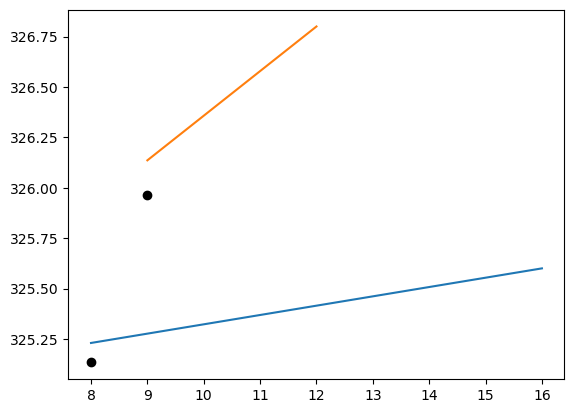

In [23]:
# TODO: plot final figure here later so anyone can compare their own run with OPLS.
# TODO: keep improving the cost effectiveness.

import matplotlib.pyplot as plt
# between 1 to 2 day of running, a main-text figure but with OPLS (*without error bars) looks like this so far:
# pgm:
plt.plot([8,16],[325.23,325.6], color='C0')
plt.plot([9,12],[326.136,326.80], color='C1')
# ecm: [not converged: second estimate unstable; log_of_BAR_results jumping by ~3/9 kT when sampling lambda 0.984375; needs more sampling]
plt.scatter([8,9],[2601.06552982219/8,  2933.68/9], color='black') 

# error bars not shown because need to move back files first, not yet finished.

# interpretation:
# - more n_mol needed here to confirm the FE difference from these methods
# + The sign of the FE difference is now correct with OPLS (form I is more stable, matching experimental knowledge).

# running the same scripts with FF_name = 'GAFF' instead, should recreate the figure from the paper (please email if there are discrepancies).